<a href="https://colab.research.google.com/github/apitongcm/Research-Machine-Learning/blob/main/Indoor_Air_Quality_within_Iloilo_using_Hybrid_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

within Iloilo City University - Applying Hybrid Model (K-Cluster & Random Forest), Unsupervised Model with DBSCAN and Isolation forest to Identify Indoor Air Quality

In [1]:
#import libraries
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Data Extraction from Dataset

In [2]:
#due to confidentiality of dataset I will not include it here.
#conversion from .xlsx --> .csv
sheet_url = "https://docs.google.com/spreadsheets/d/XXXXXXXXXXXX"

df = pd.read_csv(sheet_url)

#validation that dataset is working.
print(df.shape)
print(df.columns)
df.head()

(98798, 8)
Index(['transID', 'date_time', 'stationID', 'tvoc', 'eCO2', 'humidity',
       'temperature', 'dustDensity'],
      dtype='object')


,transID,date_time,stationID,tvoc,eCO2,humidity,temperature,dustDensity
0,37,5/30/24 9:42,RM101,0.0,400.0,83,27,0
1,38,5/30/24 9:47,RM101,0.0,414.0,77,29,15
2,39,5/30/24 9:59,RM101,0.0,450.0,74,30,15
3,40,5/30/24 10:04,RM101,0.0,436.0,70,31,14
4,41,5/30/24 10:09,RM101,0.0,400.0,70,31,16


Cleaning and Filtering of Data

In [3]:
features = ["tvoc", "eCO2", "humidity", "temperature", "dustDensity"]

# Define numeric constraints for all sensor fields
valid_df = df[
    (df["tvoc"].between(0, 9999.99, inclusive="neither")) &
    (df["eCO2"].between(0, 9999.99, inclusive="neither")) &
    (df["humidity"].between(0, 9999.99, inclusive="neither")) &
    (df["temperature"].between(0, 9999.99, inclusive="neither")) &
    (df["dustDensity"].between(0, 9999.99, inclusive="neither"))
].copy()

X = valid_df[features].astype(float)
print("Rows after cleaning: ", X.shape[0])

Rows after cleaning:  24065


Scaling of Features (K-Means and PCA Fairness)

In [4]:
#standardization
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

#scaled Dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns = features, index=X.index)

X_scaled_df

,tvoc,eCO2,humidity,temperature,dustDensity
6,-0.437766,-0.533453,0.340089,0.354709,-1.272401
8,-0.393305,-0.502788,-0.393990,1.050056,1.071134
10,-0.367033,-0.473827,-0.944549,1.050056,-0.100634
11,-0.432714,-0.566673,-0.761030,1.745402,-0.393576
12,-0.387242,-0.493418,-0.944549,1.745402,-0.686517
...,...,...,...,...,...
98598,-0.118457,0.039809,-1.678629,1.050056,0.192308
98599,-0.256891,-0.002782,-1.678629,1.050056,0.485250
98600,-0.328635,-0.041113,-1.495109,1.050056,0.485250
98601,-0.467070,-0.151847,-1.311589,1.050056,0.485250


Elbow Method - run K-Means for different cluster(K) and plot inertia (sum of squared distances).

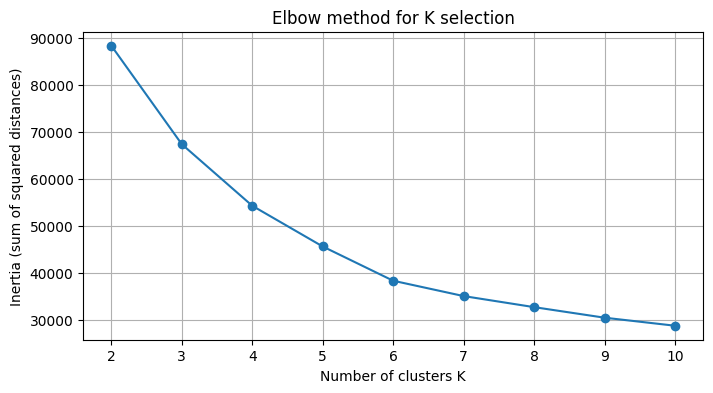

In [5]:
inertias = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

#ploting
plt.figure(figsize=(8,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow method for K selection")
plt.grid(True)
plt.show()

Checking cluster quality (Silhouette score)

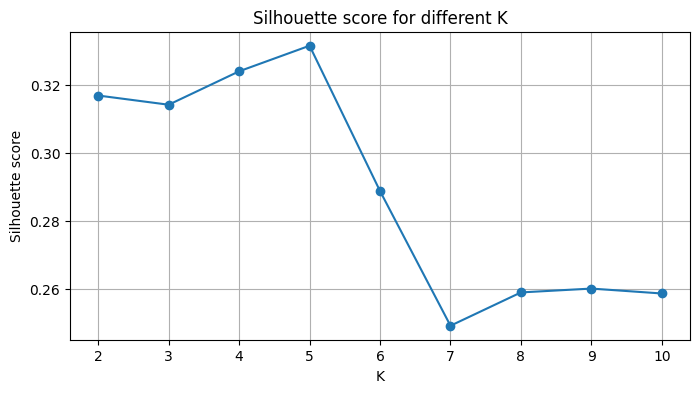

Best K by silhouette: 5 score: 0.3314507609294365


In [6]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42,n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))


#plotting
plt.figure(figsize=(8,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette score for different K")
plt.grid(True)
plt.show()

print("Best K by silhouette:", K_range[int(np.argmax(sil_scores))], "score:", max(sil_scores))

Train K-Means and Add Cluster columns

In [7]:
#Based on Elbow Method
selected_K = 4

kmeans = KMeans(n_clusters=selected_K, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(X_scaled)
valid_df["KMeans_Cluster"] = cluster_labels

#Adding original Dataframe
valid_df = valid_df.copy()
valid_df["Cluster"] = cluster_labels
valid_df["Cluster"] = valid_df["Cluster"].astype(int)

#Validation (peek)
print(valid_df["Cluster"].value_counts().sort_index())
valid_df.head()

Cluster
0     2943
1    13144
2       68
3     7910
Name: count, dtype: int64


,transID,date_time,stationID,tvoc,eCO2,humidity,temperature,dustDensity,KMeans_Cluster,Cluster
6,43,5/30/24 10:30,RM101,66.0,488.0,69,32,12,1,1
8,45,5/30/24 10:35,RM101,110.0,524.0,65,33,20,1,1
10,47,5/30/24 10:48,RM101,136.0,558.0,62,33,16,1,1
11,48,5/30/24 10:53,RM101,71.0,449.0,63,34,15,1,1
12,49,5/30/24 10:59,RM101,116.0,535.0,62,34,14,1,1


PCA 2D visualization (clusters) - PCA compresses your 5D data to 2D

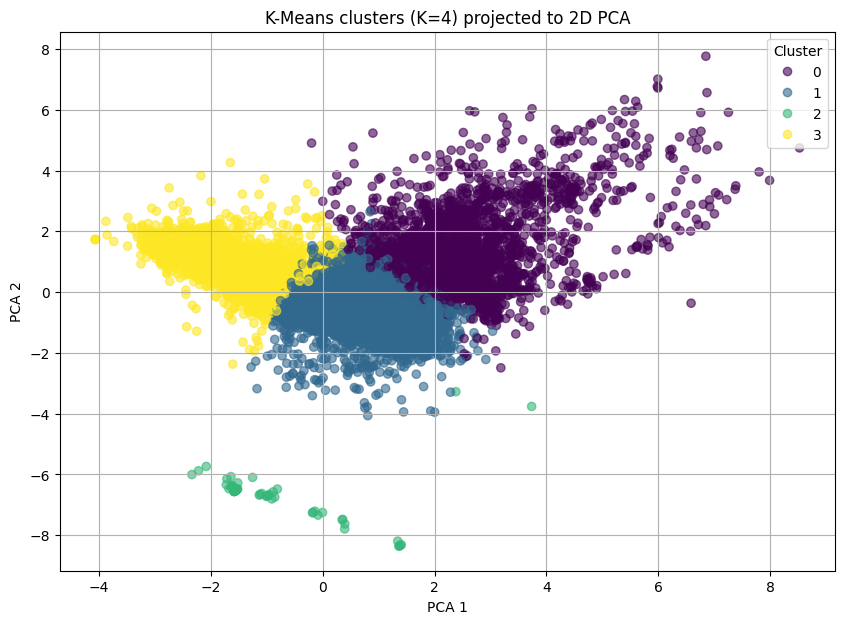

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

valid_df["PCA1"] = X_pca[:, 0]
valid_df["PCA2"] = X_pca[:, 1]

# Plot clusters in PCA plane
plt.figure(figsize=(10,7))
scatter = plt.scatter(valid_df["PCA1"], valid_df["PCA2"], c=valid_df["Cluster"], alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"K-Means clusters (K={selected_K}) projected to 2D PCA")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)

Interpretation of Clusters - summary statistics

In [21]:
cluster_summary = valid_df.groupby("Cluster")[features].agg(["mean", "std", "count"])

cluster_means = valid_df.groupby("Cluster")[features].mean().round(2)
cluster_counts = valid_df["Cluster"].value_counts().sort_index()

print("Cluster counts:\n", cluster_counts)
print("\nCluster means:\n", cluster_means)
print("\nCluster summary:\n", cluster_summary)

Cluster counts:
 Cluster
0     2943
1    13144
2       68
3     7910
Name: count, dtype: int64

Cluster means:
             tvoc     eCO2  humidity  temperature  dustDensity
Cluster                                                      
0        2224.99  3680.05     64.03        32.61        15.88
1         294.92   846.01     64.41        32.14        16.73
2         217.78   582.19     71.66        29.91        63.81
3         199.07   609.96     72.81        30.01        15.47

Cluster summary:
                 tvoc                             eCO2                      \
                mean          std  count         mean          std  count   
Cluster                                                                     
0        2224.986069  1926.834810   2943  3680.049269  1404.661353   2943   
1         294.915551   377.788992  13144   846.014075   582.039022  13144   
2         217.779412   627.892253     68   582.191176   626.249801     68   
3         199.069532   300.070885  

Mapping clusters to semantic IAQ labels and creation of IAQ index

In [28]:

cluster_to_label = {
    0: "BEST",
    1: "GOOD",
    2: "MODERATE",
    3: "POOR"
}

valid_df["IAQ_Cluster_Label"] = valid_df["Cluster"].map(cluster_to_label)
valid_df[["Cluster", "IAQ_Cluster_Label"]].head()


,Cluster,IAQ_Cluster_Label
6,1,GOOD
8,1,GOOD
10,1,GOOD
11,1,GOOD
12,1,GOOD


Random Forest (supervised)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = valid_df[["tvoc", "eCO2", "humidity", "temperature", "dustDensity"]]
y = valid_df["Cluster"]

#Training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42,
    stratify=y
)

#Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9948057344691461

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       588
           1       0.99      1.00      1.00      2629
           2       1.00      1.00      1.00        14
           3       1.00      0.99      1.00      1582

    accuracy                           0.99      4813
   macro avg       1.00      0.99      0.99      4813
weighted avg       0.99      0.99      0.99      4813



Room-based Analysis and Ranking

In [34]:
room_quality = valid_df.groupby("stationID").agg(
    Total_Records=("Cluster", "count"),

    # count how many rows belong to each cluster - here we consider "POOR" as bad
    Bad_Count=("IAQ_Cluster_Label", lambda s: (s == "POOR").sum()),
)

room_quality["Good_Count"] = room_quality["Total_Records"] - room_quality["Bad_Count"]
room_quality["Bad_%"] = (room_quality["Bad_Count"] / room_quality["Total_Records"]) * 100
room_quality["Good_%"] = 100 - room_quality["Bad_%"]

room_quality_sorted = room_quality.sort_values(by="Bad_%", ascending=False)
print(room_quality_sorted.head())


           Total_Records  Bad_Count  Good_Count       Bad_%     Good_%
stationID                                                             
RM305                  1          1           0  100.000000   0.000000
LIB01               2970       2372         598   79.865320  20.134680
GYM01               2454       1456         998   59.331703  40.668297
HUB01              13802       3807        9995   27.582959  72.417041
REGZ1                 14          2          12   14.285714  85.714286


Visualization for presentation of data

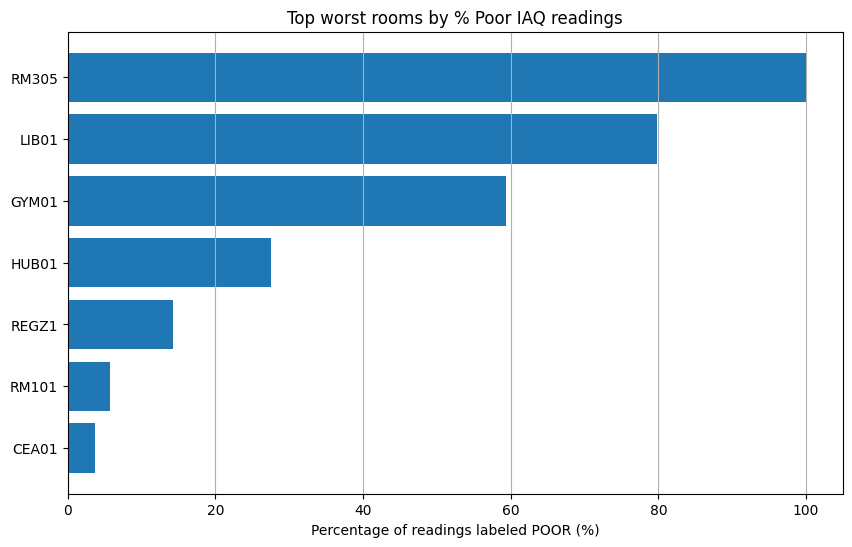

In [35]:
plt.figure(figsize=(10,6))
plt.barh(room_quality_sorted.index[::-1], room_quality_sorted["Bad_%"].values[::-1])
plt.xlabel("Percentage of readings labeled POOR (%)")
plt.title("Top worst rooms by % Poor IAQ readings")
plt.grid(axis='x')
plt.show()

Generate K-Distance Graph to decide for the value of eps (look for the "Knee" or point of maximum curvature for value of Eps.)

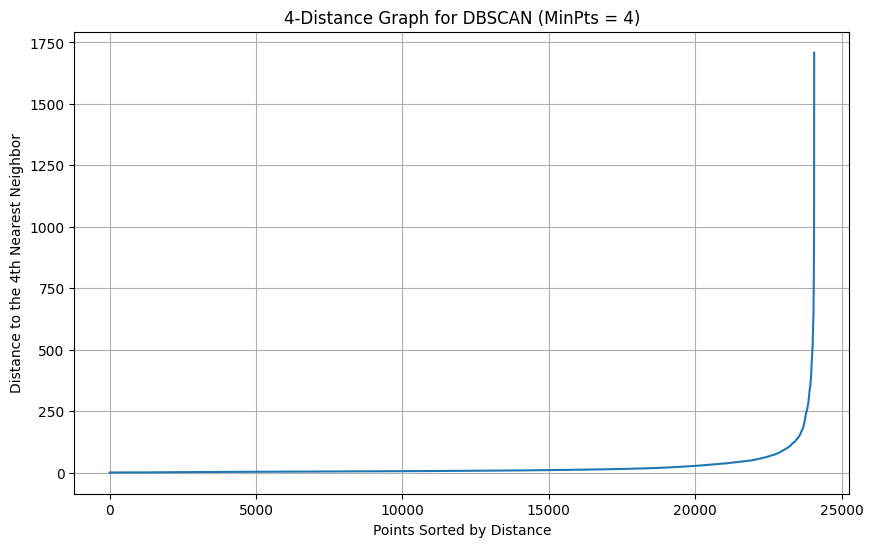

In [37]:
from sklearn.neighbors import NearestNeighbors

k = 4

neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X)

distances, indices = neigh.kneighbors(X)
k_distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title(f'{k}-Distance Graph for DBSCAN (MinPts = {k})')
plt.xlabel('Points Sorted by Distance')
plt.ylabel(f'Distance to the {k}th Nearest Neighbor')
plt.grid(True)
plt.show()

DBSCAN - density-based clustering (eps = 0.95)

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.95, min_samples=20)   #eps controls density threshold
db_labels = dbscan.fit_predict(X_scaled)

valid_df["DBSCAN_Cluster"] = db_labels

print("DBSCAN cluster counts:")
print(valid_df["DBSCAN_Cluster"].value_counts().sort_index())

DBSCAN cluster counts:
DBSCAN_Cluster
-1      514
 0    23497
 1       54
Name: count, dtype: int64


If everything becomes -1, your eps is too small. If everything becomes 1 cluster, your eps is too big.

"-1"= outliers means anomalous/unusual air conditions

"0~..." = valid clusters

DBSCAN with PCA visualization for presentation of data

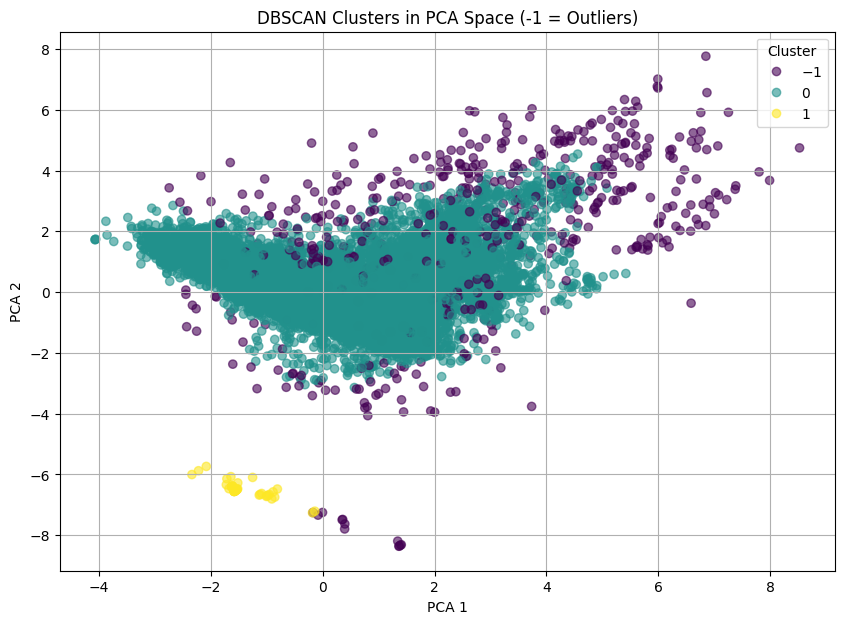

In [42]:
plt.figure(figsize=(10,7))
scatter = plt.scatter(valid_df["PCA1"], valid_df["PCA2"],
                      c=valid_df["DBSCAN_Cluster"],
                      alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("DBSCAN Clusters in PCA Space (-1 = Outliers)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

Isolation Forest (Anomaly detection)

1 = normal
-1 = anomaly likely bad/unhealthy/outlier air

In [44]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.1,   # assume 10% abnormal air
    random_state=42
)

iso_labels = iso.fit_predict(X_scaled)
valid_df['Isolation_Anomaly'] = iso_labels

valid_df["Iso_Label"] = iso_labels
print(valid_df["Iso_Label"].value_counts())

Iso_Label
 1    21658
-1     2407
Name: count, dtype: int64


Room-based comparison

In [46]:
room_anomaly = valid_df.groupby("stationID").agg(
    Total=("Iso_Label","count"),
    Anomaly_Count=("Iso_Label", lambda x: (x == -1).sum())
)

room_anomaly["Anomaly_%"] = (room_anomaly["Anomaly_Count"] /
                             room_anomaly["Total"]) * 100

room_anomaly = room_anomaly.sort_values("Anomaly_%", ascending=False)

print(room_anomaly)

           Total  Anomaly_Count   Anomaly_%
stationID                                  
RM305          1              1  100.000000
CEA01         27             25   92.592593
REGZ1         14              4   28.571429
RM101       4797           1323   27.579737
GYM01       2454            301   12.265689
LIB01       2970            317   10.673401
HUB01      13802            436    3.158962


Comparison of Models (K-Means Vs DBSCAN)

In [47]:
comparison = pd.DataFrame({
    "KMeans_Clusters": valid_df["Cluster"].value_counts().sort_index(),
    "DBSCAN_Clusters": valid_df["DBSCAN_Cluster"].value_counts().sort_index(),
    "IsoForest_Normal_vs_Anomaly": valid_df["Iso_Label"].value_counts()
})

print(comparison)

    KMeans_Clusters  DBSCAN_Clusters  IsoForest_Normal_vs_Anomaly
-1              NaN            514.0                       2407.0
 0           2943.0          23497.0                          NaN
 1          13144.0             54.0                      21658.0
 2             68.0              NaN                          NaN
 3           7910.0              NaN                          NaN


In [49]:
print("\nK-Means Cluster distribution per room:")
print(valid_df.groupby(['stationID','KMeans_Cluster']).size())

print("\nDBSCAN results per room:")
print(valid_df.groupby(['stationID','DBSCAN_Cluster']).size())

print("\nAnomalies per room:")
print(valid_df.groupby(['stationID','Isolation_Anomaly']).size())


K-Means Cluster distribution per room:
stationID  KMeans_Cluster
CEA01      0                    1
           1                   25
           3                    1
GYM01      0                   16
           1                  917
           2                   65
           3                 1456
HUB01      0                  414
           1                 9579
           2                    2
           3                 3807
LIB01      0                    7
           1                  590
           2                    1
           3                 2372
REGZ1      0                    1
           1                   11
           3                    2
RM101      0                 2504
           1                 2022
           3                  271
RM305      3                    1
dtype: int64

DBSCAN results per room:
stationID  DBSCAN_Cluster
CEA01      -1                    6
            0                   21
GYM01      -1                   32
            0   